Capstone project
 Estimated Time: 17-19 hours  
For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

# Data Aquisition

In [9]:
from selenium import webdriver
# from webdriver_manager.chrome import ChromeDriverManager

In [ ]:
# from scrapy.contrib.spiders import CrawlSpider
from scrapy.http import Request
from scrapy import Selector
from scrapy.crawler import CrawlerProcess
import scrapy
import time

from selenium import webdriver

class NPRSpider(scrapy.Spider):
    name = 'npr-spider'
    allowed_domains = ['www.npr.org']

    def start_requests(self):
        urls = ['https://www.npr.org/people/473143808/alison-kodjak/archive', 
                'https://www.npr.org/people/348766539/greg-myre/archive', 
                'https://www.npr.org/people/2788801/scott-horsley/archive',
                'https://www.npr.org/people/5201175/michel-martin/archive',
                'https://www.npr.org/people/2100631/richard-harris/archive',
                'https://www.npr.org/people/2101154/ari-shapiro/archive',
                'https://www.npr.org/people/7569853/russell-lewis/archive',
                'https://www.npr.org/people/146944972/rob-stein/archive',
                'https://www.npr.org/people/544275644/ryan-lucas/archive',
                'https://www.npr.org/people/2101062/philip-reeves/archive',
                'https://www.npr.org/people/279612138/geoff-brumfiel/archive']
        
        for start_url in urls:
            print('\n',start_url)
            yield Request(url = start_url, callback=self.parsencmilllist)

    def parsencmilllist(self, response):
        driver = webdriver.Chrome(executable_path='./chromedriver')
        driver.get(response.url)
        time.sleep(2)
        
        for i in range(1,10):
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(4)
        sel = Selector(text=driver.page_source)

        links = sel.xpath('//li[@class = "audio-tool audio-tool-transcript"]//a/@href').extract()
        for link in links:
            print(len(links))
            yield Request(link,
                          meta={'type': 'Milling'},
                          callback=self.parsencmachine)

    def parsencmachine(self, response):
            
        for article in [response.xpath('//article[@class="story"]')]:
            print(article.xpath('//div[@class="storytitle"]/h1[@class = "transcript"]/a/text()').extract())
            yield {
                    'text': article.xpath('//div[@class="transcript storytext"]').extract(),#.xpath('a/@href').extract(),
                    'title': article.xpath('//div[@class="storytitle"]/h1[@class = "transcript"]/a/text()').extract(),
                                }

process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'npr_url_text.json',       # Name our storage file.
    'LOG_ENABLED': False,          # Turn off logging for now.
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True
})

# Start the crawler with our spider.
process.crawl(NPRSpider)
process.start()
print('Success!')

# Data wrangling

## Load

In [94]:
import pandas as pd
npr_raw = pd.read_json('npr_url_text.json')

## Split into parts

In [95]:
story_text = []
titles_tmp = []
for ik in range(len(npr_raw)): 
    txt = (npr_raw.text[ik][0].split('</b>\n\n    <p>')[1]).split('</p>\n\n    <p class="disclaimer">C')[0]
    story_text.append(' '.join(txt.split('</p>\n    <p>',1)))
    titles_tmp.append(npr_raw.iloc[ik]['title'][0])
    

In [96]:
npr_raw['title'] = titles_tmp
npr_raw['text'] = story_text
npr_raw= npr_raw.drop_duplicates()
npr_raw = npr_raw.reset_index(drop=True)

In [87]:
import re
import string


def cat_npr_text(story, title):
    names = ['alison kodjak', 'greg myre', 'scott horsley','michel martin','richard harris','ari shapiro','russell lewis',
         'rob stein','ryan lucas','philip reeves','geoff brumfiel']
    
    speakers = []
    comments = []
    d = {'host': '', 'byline': ''}
    
    story = re.sub(r'([A-Z])-([A-Z])', r'\1\2', story)
    story = re.sub(r'([A-Z])\'([A-Z])', r'\1\2', story)
    
    story = re.sub(r'(</p>\n    <p>)([A-Z]{4})', r'\1</p>\n    <p> \2',  story)
    story = re.sub(r'(</p>\n    <p>)\(([A-Z]{4})', r'\1</p>\n    <p> \2',  story)
    lines = story.split('</p>\n    <p></p>\n    <p> ')
    lines = [line.replace('</p>\n    <p>', ' ') for line in lines ]
    
    for ik, line in enumerate(lines):
        if 'SOUNDBITE' not in line:
            try:
                [speaker, comment] = line.split(':', 1)
            except:
                pass
            for label in [['HOST', 'host'],['BYLINE', 'byline'] ]:
                if len(speaker.split(label[0]))>1:
                    speaker = speaker.split(label[0])[0].strip(', ').split(' ')[-1]
                    d[label[1]] = speaker

            speakers.append(speaker)
            for name in names: 
                comment = comment.lower().replace(name, ' ')
            comments.append(comment)

    host_cs = [1 if speaker == d['host'] else 0 for speaker in speakers]
    byline_cs = [1 if speaker == d['byline'] else 0 for speaker in speakers]
    return speakers, comments, host_cs, byline_cs

In [98]:
speakers = []
comments = []
host_cs = []
byline_cs = []
titles = []

for ik, story in enumerate(npr_raw['text']):
    spkrs, cmmnts, hst_cs, bylne_cs = cat_npr_text(story, npr_raw.loc[ik, 'title'])
    titles = titles + [npr_raw.loc[ik, 'title'] for im in range(len(spkrs))]
    speakers = speakers+spkrs
    comments = comments +cmmnts
    host_cs = host_cs + hst_cs
    byline_cs = byline_cs +bylne_cs

In [99]:
npr_df = pd.DataFrame({'speaker': speakers, 'comment':comments, 'host': host_cs, 'byline':byline_cs, 'title': titles})

In [101]:
len(npr_df)

23076

In [120]:
grps = culled_npr.groupby('speaker')
len(grps)
for grp in grps:
    print(grp[0], len(grp[1].groupby('title')))

BRUMFIEL 105
HARRIS 121
HORSLEY 102
KODJAK 28
LEWIS 69
LUCAS 103
MARTIN 246
MYRE 12
REEVES 138
SHAPIRO 228
STEIN 119


## Cull

In [118]:
reporters = ['KODJAK', 'MYRE', 'HORSLEY', 'MARTIN', 'HARRIS', 'SHAPIRO', 'LEWIS', 'STEIN', 'LUCAS', 'REEVES', 'BRUMFIEL']

culled_npr = npr_df[npr_df['speaker'].isin(reporters)]

In [121]:
# npr_bystory_df 

grps_title = culled_npr[culled_npr.host != 1].groupby('title')

speakers = []
speaker_texts =[]
titles = []
ids = []

for ik, grp in enumerate(grps_title):
    title = grp[0]
    grps_speaker = grp[1].groupby('speaker')
    for grp2 in grps_speaker:
        speaker_text = speaker_texts.append(' '.join(grp2[1].comment))
        speakers.append(grp2[0])
        titles.append(title)
        ids.append(grp2[0]+str(ik))
        
npr_bystory_df = pd.DataFrame({'ids': ids, 'speaker':speakers, 'comment_text':speaker_texts, 'title':titles})

## Clean

In [10]:
import spacy
nlp = spacy.load('en')    

In [11]:
from collections import Counter
import string

# Utility function to create a list of the 3000 most common words from a block of text.
def clean_text(text, **kwargs):
    
    # Filter out punctuation and stop words.
    if ('no_stop_words' in kwargs) and (kwargs['no_stop_words'] == True):
#         print('bag_of_words: no_stop_words')
        allwords = [str(token.lemma_).translate(str.maketrans('', '', string.punctuation)).lower()
                for token in text
                if not token.is_punct
                  and not token.is_stop
                  and token.is_alpha]
    else:
#         print('bag_of_words: stop_words')
        allwords = [str(token.lemma_).translate(str.maketrans('', '', string.punctuation)).lower()
                for token in text
                if not token.is_punct
                  and token.is_alpha]
    
    # Return the most common words.
    return ' '.join(allwords)

In [122]:
culled_npr['cleaned_text'] = [clean_text(nlp(line), no_stop_words = True) for line in culled_npr.comment]

In [123]:
npr_bystory_df['cleaned_text'] = [clean_text(nlp(text), no_stop_words = True) for text in npr_bystory_df.comment_text]

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(npr_bystory_df)

X_train = pd.DataFrame(X_train, columns = npr_bystory_df.columns)
X_test = pd.DataFrame(X_test, columns = npr_bystory_df.columns)

In [125]:
from gensim.models.doc2vec import TaggedDocument
from nltk import word_tokenize

tagged = [TaggedDocument(words = word_tokenize(comment.lower()), tags = [str(ik)]) for  ik, comment in enumerate(X_train['cleaned_text'])]


In [126]:
from gensim.models import Doc2Vec
import time

def train_model(tagged_vects, params):
    max_epochs = 200

    model = Doc2Vec(**params)

    model.build_vocab(tagged_vects)

    t1 = time.time()
    for epoch in range(max_epochs):
        model.train(tagged, total_examples = model.corpus_count, epochs = model.iter)
        model.alpha -= .0001
        model.min_alpha = model.alpha

    t2 = time.time()
    print('Time: {}'.format(t2-t1))
    return model

In [127]:
def make_d2v_df(model, tagged_vects):
    return pd.DataFrame([model.docvecs[ik] for ik in range(len(tagged_vects))])

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc, silhouette_score

def make_clusters(d2v_vecs_df):
    nclusts = []
    sscores = [] 
    avg_obs = []
    obs_std = []
    models = []

    for no in range(3,50,1):
        t1 = time.time()
        fd2v_clusters = KMeans(n_clusters=no, random_state=43).fit_predict(d2v_vecs_df)    
        nclusts.append(no)
        sscores.append(silhouette_score(d2v_vecs_df, fd2v_clusters, metric='cosine'))
        avg_obs.append(pd.value_counts(fd2v_clusters).mean())
        obs_std.append(pd.value_counts(fd2v_clusters).std())
        models.append(fd2v_clusters)
#     print(nclusts[np.array(sscores).argmax()], 'clusters, score:', max(np.array(sscores)))
#     print("done!")
    return models, pd.DataFrame({'nclusts':nclusts, 'sscores':sscores, 'avg_obs':avg_obs, 'obs_std':obs_std})

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Visualize Results
def make_sil_plot(df):
    obsstd1 = [ i+j for i,j in zip(df['avg_obs'],df['obs_std'])]
    stdneg = [ i-j for i,j in zip(df['avg_obs'],df['obs_std'])]

    sns.set(context='notebook', style='dark')
    fig, ax = fig, ax = plt.subplots(figsize=(6,4))

    ax2 = ax.twinx()
    ax = sns.lineplot(df['nclusts'], df['sscores'],color='g', label='Sil. Score', linewidth=2, ax=ax)
    ax2 =sns.lineplot(df['nclusts'], df['avg_obs'],color='purple',label='Avg obs per cluster', linewidth=2)
    sns.lineplot(df['nclusts'],obsstd1,color='r',label='+/- Std Avg Obs', linewidth=.6)
    sns.lineplot(df['nclusts'],stdneg,color='r', linewidth=.6)

    ax.set_ylabel('Sil. Score')
    ax.set_xlabel('Number of Clusters')
    ax.axvline(x=df['nclusts'].iloc[df['sscores'].argmax()],color='r',linestyle='dotted')

    ax.legend(loc='lower left')
    ax2.legend(loc='upper right')
    plt.ylabel('Average Observation per cluster')
    plt.xlabel('Number of Clusters')
    plt.title('Silhouette Scores by Number of Clusters',fontsize=20)
    #
    plt.savefig("silscores.png")

In [19]:
from sklearn.manifold import TSNE
def fit_tsne(num_clusters, d2v_vecs_df,X_train):
    tsne = TSNE(n_components=2, random_state=43)
    #create dataframe for plotting, add comoonents,labels
    tsne_plot_df = pd.DataFrame()
    tsne_plot_df['original'] = X_train['cleaned_text']
    tsne_plot_df['ids'] = X_train['ids']
    # tsne_plot['Subject'] = y_train[:,2]
    # tsne_plot['filename'] = y_train[:,0]

    #get cluster assignments from KMeans
    d2v_clusterst = KMeans(n_clusters=num_clusters, random_state=43).fit_predict(d2v_vecs_df)

    tsne_plot_df['clusters'] = d2v_clusterst

    #fit transform doc2vec word vectors
    Yt = tsne.fit_transform(d2v_vecs_df)
    tsne_plot_df['TSNE_1'] = Yt[:,0]
    tsne_plot_df['TSNE_2'] = Yt[:,1]
    return tsne_plot_df

In [26]:
def make_tsne_plot(tsne_plot_df, num_clusters):
    plt.figure(figsize=(6,5))
    sns.despine(left=True)

    sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='clusters', data=tsne_plot_df, palette='BrBG', legend='full',
                    edgecolor='black', s=40).set_title('KMeans {} clusters'.format(num_clusters))
    plt.legend(loc='lower right')
    plt.xlim([tsne_plot_df['TSNE_1'].min()*1.2, tsne_plot_df['TSNE_1'].max()*1.2])
    plt.ylim([tsne_plot_df['TSNE_2'].min()*1.2, tsne_plot_df['TSNE_2'].max()*1.2])
    plt.show()

In [129]:
params = {'vector_size' : 200, 'alpha' : .025, 'min_alpha' : .0001, 'min_count' : 7, 'dm' :1, 'window':0, 'negative':0}

param_lst = []
scores = []
clusters = []

alpha_range = list(np.arange(.01,.04,.01))
min_count_range = [10]#list(range(10,16,2))
vector_size_range = list(range(20,50,20))
negative_range = [1]#list(range(1,2))
window_range = list(range(3,6))
dm_range = [0,1]

print('total number of combinations:', len(dm_range)*len(alpha_range)*len(min_count_range)*len(vector_size_range)*len(negative_range)*len(window_range))
ik = 0
for min_count in min_count_range:
    params['min_count'] = min_count
    for vector_size in vector_size_range:
        params['vector_size'] = vector_size
        for negative in negative_range:
            params['negative'] = negative
            for window in window_range:
                params['window'] = window
                for alpha in alpha_range:
                    params['alpha'] = alpha
                    for dm in dm_range:
                        params['dm'] = dm
                        param_lst.append(params.copy())
                        
def test_doc2vec_cluster_params(tagged, params):
    model = train_model(tagged, params)
    d2v_vecs = make_d2v_df(model, tagged)
    kmeans_mdls, df_clusters = make_clusters(d2v_vecs)
    scores.append(max(df_clusters['sscores']))
#         make_sil_plot(df_clusters)
    num_clusters = df_clusters['nclusts'].iloc[df_clusters['sscores'].idxmax()]
    clusters.append(num_clusters)
#                 tsne_plot_df = fit_tsne(num_clusters, d2v_vecs,X_train)
#         make_tsne_plot(tsne_plot_df, num_clusters)
    print(ik, max(df_clusters['sscores']),num_clusters, '\n')
    d['num_clusters' = num_clusters, 'score': max(df_clusters['sscores']), 'params': params]
    return d
      
# multiprocessing untested
import multiprocessing

pool = mp.Pool(processes=3)
results = pool.map(test_doc2vec_cluster_params, iter(param_lst))
pool.close()



total number of combinations: 36
Time: 45.81631684303284
0 0.16755387106428907 24 

Time: 74.80816411972046
1 0.2102204930096683 5 

Time: 43.982288122177124
2 0.17557395880917337 19 

Time: 77.62587904930115
3 0.20708767664148173 5 

Time: 39.299006938934326
4 0.16874021528464095 15 

Time: 77.70320987701416
5 0.19837957743545437 5 

Time: 48.57042098045349
6 0.17087353691696125 19 

Time: 64.32733488082886
7 0.20187486297031884 5 

Time: 48.90810966491699
8 0.16767836782221618 10 

Time: 70.264652967453
9 0.19731670045009997 8 

Time: 60.29147434234619
10 0.18334181257975796 15 

Time: 65.67886209487915
11 0.19117300651554323 8 

Time: 45.0357711315155
12 0.17812924919109793 24 

Time: 72.82378888130188
13 0.19078204471702667 5 

Time: 43.0838098526001
14 0.16896424894369008 20 

Time: 89.99061703681946
15 0.18654659594023082 9 

Time: 53.133960247039795
16 0.17699665452172567 15 

Time: 73.72491884231567
17 0.18186076379666755 10 

Time: 42.349822998046875
18 0.08955077629876672 16 

In [130]:
inds = np.argwhere(np.array(scores)>.20)

In [131]:
for ind in inds:
    print(clusters[ind[0]], scores[ind[0]], param_lst[ind[0]])

5 0.2102204930096683 {'vector_size': 20, 'alpha': 0.01, 'min_alpha': 0.0001, 'min_count': 10, 'dm': 1, 'window': 3, 'negative': 1}
5 0.20708767664148173 {'vector_size': 20, 'alpha': 0.02, 'min_alpha': 0.0001, 'min_count': 10, 'dm': 1, 'window': 3, 'negative': 1}
5 0.20187486297031884 {'vector_size': 20, 'alpha': 0.01, 'min_alpha': 0.0001, 'min_count': 10, 'dm': 1, 'window': 4, 'negative': 1}


Time: 67.85616397857666


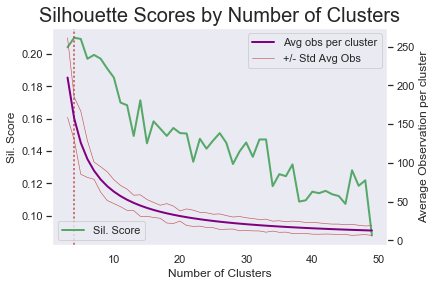

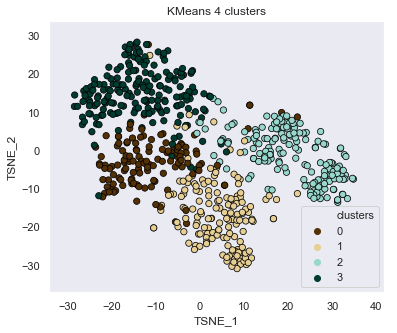

{'vector_size': 20, 'alpha': 0.01, 'min_alpha': 0.0001, 'min_count': 10, 'dm': 1, 'window': 3, 'negative': 1}


In [132]:
params = param_lst[np.array(scores).argmax()]

model = train_model(tagged, params)
d2v_vecs = make_d2v_df(model, tagged)
kmeans_mdls, df_clusters = make_clusters(d2v_vecs)
make_sil_plot(df_clusters)
num_clusters = df_clusters['nclusts'].iloc[df_clusters['sscores'].argmax()]
kmeans_mdl = kmeans_mdls[df_clusters['sscores'].argmax()][0]
tsne_plot_df = fit_tsne(num_clusters, d2v_vecs,X_train)
make_tsne_plot(tsne_plot_df, num_clusters)
print(params)

In [133]:
X_train['labels'] = kmeans_mdls[df_clusters['sscores'].argmax()]

In [137]:
label_grps = X_train.groupby('labels')
for grp in label_grps:
    print(grp[0])
    print(set(grp[1]['speaker']), len(set(grp[1]['speaker'])), len(grp[1]))

0
{'LEWIS', 'SHAPIRO', 'MYRE', 'BRUMFIEL', 'HARRIS', 'REEVES', 'MARTIN', 'HORSLEY', 'STEIN'} 9 125
1
{'LEWIS', 'LUCAS', 'SHAPIRO', 'KODJAK', 'BRUMFIEL', 'REEVES', 'MARTIN', 'HORSLEY', 'STEIN'} 9 150
2
{'LEWIS', 'LUCAS', 'SHAPIRO', 'MYRE', 'KODJAK', 'BRUMFIEL', 'HARRIS', 'HORSLEY', 'MARTIN', 'STEIN'} 10 164
3
{'LEWIS', 'SHAPIRO', 'KODJAK', 'BRUMFIEL', 'HARRIS', 'MARTIN', 'STEIN'} 7 191


In [138]:
from sklearn.metrics.pairwise import cosine_similarity

d2v_fullsim = pd.DataFrame(cosine_similarity(d2v_vecs), index=X_train['ids'], columns=X_train['ids'])

In [139]:
d2v_fullsim.describe()

ids,LUCAS388,HARRIS512,HORSLEY710,BRUMFIEL612,LUCAS792,BRUMFIEL50,BRUMFIEL285,HORSLEY706,REEVES606,REEVES645,...,STEIN566,REEVES498,REEVES31,REEVES280,HARRIS173,KODJAK435,HORSLEY702,MARTIN434,SHAPIRO328,LUCAS53
count,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,...,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,0.342971,0.280744,0.318212,0.379893,0.335948,0.384306,0.344289,0.296681,0.348378,0.288777,...,0.355826,0.335367,0.354004,0.328731,0.349994,0.350451,0.338067,0.358074,0.298256,0.361914
std,0.185652,0.247807,0.185195,0.176215,0.187034,0.173004,0.148647,0.209107,0.163911,0.200652,...,0.177641,0.186114,0.197376,0.173900,0.183508,0.165984,0.163665,0.172417,0.175638,0.168466
min,-0.133559,-0.216874,-0.121841,-0.057329,-0.101269,-0.088382,-0.058924,-0.256084,-0.046855,-0.214862,...,-0.106855,-0.117361,-0.115331,-0.136936,-0.083969,-0.003389,-0.084484,-0.070471,-0.171011,-0.078963
25%,0.218426,0.088459,0.186813,0.253557,0.197844,0.265650,0.243322,0.150337,0.230786,0.132254,...,0.227714,0.209186,0.214026,0.208318,0.209010,0.231072,0.224092,0.233621,0.178507,0.247533
50%,0.317399,0.230820,0.311450,0.364490,0.311157,0.368550,0.337277,0.293027,0.333243,0.284481,...,0.332569,0.316942,0.327996,0.316853,0.336633,0.330825,0.340443,0.356397,0.289488,0.339977
75%,0.440506,0.479256,0.434559,0.488054,0.457468,0.495355,0.436471,0.451768,0.451968,0.426396,...,0.472768,0.459054,0.491919,0.447161,0.482107,0.451281,0.451402,0.485918,0.416689,0.457531
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [140]:
from sklearn.decomposition import TruncatedSVD, NMF, PCA

# instantiate the PCA module with two components so we can visualize the results
pca = PCA(n_components=2, random_state=43)

#create dataframe for plotting, add comoonents,labels
pca_plot = pd.DataFrame()
pca_plot['original'] = X_train['cleaned_text']
pca_plot['ids'] = X_train['ids']

#get cluster assignments from KMeans Clustering
d2v_clusters = KMeans(n_clusters=num_clusters, random_state=43).fit_predict(d2v_vecs)
pca_plot['clusters'] = d2v_clusters
#fit transform doc2vec word vectors append to DF for plotting
Y = pca.fit_transform(d2v_vecs)
pca_plot['PCA_1'] = Y[:,0]
pca_plot['PCA_2'] = Y[:,1]

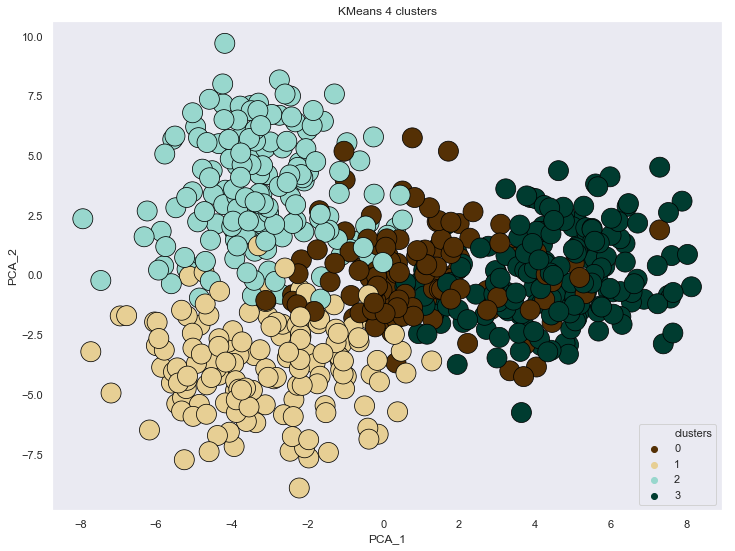

In [141]:
plt.figure(figsize=(12,9))
sns.despine(left=True)

sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters', data=pca_plot, palette='BrBG', legend='full',
                edgecolor='black', s=400).set_title('KMeans {} clusters'.format(num_clusters))
plt.legend(loc='lower right')
plt.show()

In [148]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
def train_test_log_reg(d):
    data = d['data']
    gs_params = {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
    lr = LogisticRegression(multi_class = 'auto', solver = 'lbfgs')
    lr.fit(data['X_train'], data['y_train'])
    d['model'] = lr
    d['train_score'] = lr.score(data['X_train'], data['y_train'])
    d['test_score'] = lr.score(data['X_test'], data['y_test'])
    print(d['label'], 'Training set score:',d['train_score'], 'Test set score:', d['test_score'] )

    y_pred = lr.predict(data['X_test'])
    print(pd.crosstab(y_pred, data['y_test'], dropna=False))
    return d

In [144]:
tagged_X_train = [TaggedDocument(words = word_tokenize(comment.lower()), tags = [str(ik)]) for  ik, comment in enumerate(X_train['cleaned_text'])]
tagged_X_test = [TaggedDocument(words = word_tokenize(comment.lower()), tags = [str(ik)]) for  ik, comment in enumerate(X_test['cleaned_text'])]

model = train_model(tagged_X_train, params)
d2v_vecs_X_train = make_d2v_df(model, tagged_X_train)
d2v_vecs_X_test = make_d2v_df(model, tagged_X_test)

d = {'label': 'doc2vec', 'data':{'X_train': d2v_vecs_X_train, 'y_train': X_train['speaker'], 'X_test':d2v_vecs_X_test, 'y_test':X_train['speaker'] }}
d = train_test_log_reg(d)

Time: 66.1455409526825
doc2vec Training set score: 0.8761904761904762 Test set score: 0.8761904761904762


In [149]:
d = train_test_log_reg(d)

doc2vec Training set score: 0.8761904761904762 Test set score: 0.8761904761904762
speaker   BRUMFIEL  HARRIS  HORSLEY  KODJAK  LEWIS  LUCAS  MARTIN  MYRE  \
row_0                                                                     
BRUMFIEL        68       2        1       0      8      0       0     1   
HARRIS           2      77        0       0      0      0       0     0   
HORSLEY          1       1       75       0      1      0       0     1   
KODJAK           0       1        0      15      0      0       0     0   
LEWIS            3       1        0       0     42      0       0     0   
LUCAS            0       0        0       0      0     71       0     0   
MARTIN           0       0        1       0      0      0       7     0   
MYRE             0       0        0       0      0      0       0     3   
REEVES           0       0        0       0      2      0       1     0   
SHAPIRO          0       2        1       0      2      0       0     0   
STEIN            6

In [151]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(d['data']['X_train'], d['data']['y_train'])
print(d['label'], 'Training set score:',gbc.score(d['data']['X_train'], d['data']['y_train']), 'Test set score:', gbc.score(d['data']['X_test'], d['data']['y_test']) )

y_pred = gbc.predict(d['data']['X_test'])
pd.crosstab(y_pred, d['data']['y_test'], dropna=False)

doc2vec Training set score: 1.0 Test set score: 1.0


speaker,BRUMFIEL,HARRIS,HORSLEY,KODJAK,LEWIS,LUCAS,MARTIN,MYRE,REEVES,SHAPIRO,STEIN
row_0,,,,,,,,,,,
BRUMFIEL,80,0,0,0,0,0,0,0,0,0,0
HARRIS,0,93,0,0,0,0,0,0,0,0,0
HORSLEY,0,0,78,0,0,0,0,0,0,0,0
KODJAK,0,0,0,16,0,0,0,0,0,0,0
LEWIS,0,0,0,0,57,0,0,0,0,0,0
LUCAS,0,0,0,0,0,71,0,0,0,0,0
MARTIN,0,0,0,0,0,0,8,0,0,0,0
MYRE,0,0,0,0,0,0,0,5,0,0,0
REEVES,0,0,0,0,0,0,0,0,106,0,0


In [152]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(d['data']['X_train'], d['data']['y_train'])
print(d['label'], 'Training set score:',svc.score(d['data']['X_train'],d['data']['y_train']), 'Test set score:', svc.score( d['data']['X_test'],  d['data']['y_test']) )

y_pred = svc.predict( d['data']['X_test'])
pd.crosstab(y_pred,  d['data']['y_test'], dropna=False)

doc2vec Training set score: 0.9936507936507937 Test set score: 0.9936507936507937


speaker,BRUMFIEL,HARRIS,HORSLEY,KODJAK,LEWIS,LUCAS,MARTIN,MYRE,REEVES,SHAPIRO,STEIN
row_0,,,,,,,,,,,
BRUMFIEL,80,0,0,0,0,0,0,0,0,0,0
HARRIS,0,93,0,0,0,0,0,0,0,0,0
HORSLEY,0,0,78,0,0,0,0,1,0,0,0
KODJAK,0,0,0,16,0,0,0,0,0,0,0
LEWIS,0,0,0,0,57,0,0,0,1,1,0
LUCAS,0,0,0,0,0,71,0,0,0,0,0
MARTIN,0,0,0,0,0,0,7,0,0,0,0
MYRE,0,0,0,0,0,0,0,4,0,0,0
REEVES,0,0,0,0,0,0,1,0,105,0,0


In [153]:
from sklearn.feature_extraction.text import TfidfVectorizer

# X_train, X_test, y_train, y_test = train_test_split(filtered_ww_longlines['line'], filtered_ww_longlines['character'], test_size=0.3, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.6, # drop words that occur in more than half the paragraphs
                             min_df=3, # only use words that appear at least twice
                             stop_words='english', 
                             ngram_range = (1,2),
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
npr_tfidf=vectorizer.fit(X_train['cleaned_text'])

#splitting into training and test sets
npr_tfidf_train=vectorizer.transform(X_train['cleaned_text'])
print("Number of features: %d" % npr_tfidf_train.get_shape()[1])

npr_tfidf_test=vectorizer.transform(X_test['cleaned_text'])


Number of features: 7505


In [156]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(500)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
npr_lsa = lsa.fit(npr_tfidf_train)

npr_tfidf_lsa_train = npr_lsa.transform(npr_tfidf_train)
npr_tfidf_lsa_test = npr_lsa.transform(npr_tfidf_test)


# X_train_lsa = lsa.fit_transform(X_train_tfidf)
# X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(npr_tfidf_lsa_train,index=X_train['cleaned_text'])
paras_by_component['speaker'] = X_train['speaker']
for i in range(1, 10,1):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[:10])

Percent variance captured by all components: 92.94172743390936
Component 1:
cleaned_text
good morning meeting take place trump tower june summer presidential campaign meeting set donald trump jr music producer music promotional guy donald trump jr jar kushner donald trump son law paul manafort campaign chairman meet russian lawyer offer damaging information hillary clinton trump jr say meeting ultimately last minute talk russian adoption policy sanction sort dirt hillary clinton characterize meeting bust meeting important moment investigator trump campaign official sit room russian proxy offer information trump opponent linger question president know russian effort contact help campaign white house donald trump jr say president know trump tower meeting find year remember know president help draw statement trump jr release new york time break story summer meeting know trump lawyer acknowledge writing trump know big point draw direct line russian donald trump see trump jr testify congres